In [260]:
import pandas as pd
import matplotlib.ticker as tick
import matplotlib.pylab as plt
import seaborn as sns

from util.reformat_large_tick_values import reformat_large_tick_values
from sqlalchemy.engine import create_engine

engine = create_engine('bigquery://', credentials_path= 'key/iowa-liquor-sales-365322-12ff7a5498e6.json')

Set font scale. Establish color palette. 
Color palette "county_colors" (modified from "tab10"), one color for each of ten featured Iowa counties. 

In [261]:
sns.set(font_scale = 1.4)
colors = ['#1f77b4', '#9467bd', '#e377c2', '#17becf', '#2ca02c', '#bcbd22', '#FFEB3B', '#FFA000', '#d62728', '#873600']
county_colors = sns.color_palette(colors)
sns.color_palette(county_colors)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (1.0, 0.9215686274509803, 0.23137254901960785),
 (1.0, 0.6274509803921569, 0.0),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5294117647058824, 0.21176470588235294, 0.0)]

# Public Datasets:  
Iowa Liquor Sales dataset, Iowa Department of Commerce, Alcoholic Beverages Division
 `bigquery-public-data.iowa_liquor_sales`  
 Population data, United States Census Bureau, https://www.census.gov/quickfacts/fact/table/IA/POP010220

## Cleaning:
Null check on Iowa Liquor Sales dataset columns: volume_sold_liters, county

In [262]:
null_check_liters_sold_sql_statement = """
SELECT 
  countif(volume_sold_liters is null) / count(1) * 100 as percent_null_liters_sold
FROM `bigquery-public-data.iowa_liquor_sales.sales` 
WHERE EXTRACT(YEAR from date) IN (2017, 2018,2019, 2020, 2021)
  """.strip()
percent_null_liters_sold = pd.read_sql_query(null_check_liters_sold_sql_statement, engine)
percent_null_liters_sold

,percent_null_liters_sold
0,0.0


In [263]:
null_check_county_sql_statement = """SELECT 
  countif(county is null) / count(1) * 100 as percent_null_county
FROM `bigquery-public-data.iowa_liquor_sales.sales` 
WHERE EXTRACT(YEAR from date) IN (2017, 2018, 2019, 2020, 2021)
  """.strip()
percent_null_county = pd.read_sql_query(null_check_county_sql_statement, engine)
percent_null_county

,percent_null_county
0,0.409401


41% of values in the county column are null, but only 1% of values in store_number column are null. There are 2,299 distinct store numbers, only two are missing valid county name. 

Strategy: Clean county column by mapping each store number to a valid county name.

County column nulls reduced to < 1% 

In [264]:
cleaned_null_check_county_sql_statement = """
WITH 
source_table AS (
  SELECT
    volume_sold_liters,
    date,
    EXTRACT(YEAR FROM date) AS year,
    IF (county ='POTTAWATTA','POTTAWATTAMIE', county) AS county,
    store_number
  FROM `bigquery-public-data.iowa_liquor_sales.sales`
  WHERE EXTRACT(YEAR FROM date) IN (2017, 2018, 2019, 2020, 2021)
  ),

store_county_map AS ( 
  SELECT 
  store_number,
  MAX(county) AS county
  FROM source_table
  WHERE store_number IS NOT NULL
  GROUP BY store_number
  ),

joined_table AS (
  SELECT a.volume_sold_liters, a.date, a.year, a.store_number, COALESCE(a.county, b.county) AS county
  FROM source_table a
  LEFT JOIN store_county_map b ON a.store_number = b.store_number
  ),

 null_check_county AS (
   SELECT countif(county is null) / count(1) * 100 as percent_null_county
FROM joined_table)

SELECT * FROM null_check_county
  """.strip()

cleaned_percent_null_county = pd.read_sql_query(cleaned_null_check_county_sql_statement, engine)
cleaned_percent_null_county

,percent_null_county
0,0.00954


## Analysis
### Liquor Liters Sold 2018-2021
Find total volume (in liters) of liquor sold per county during 2018-2021 for ten most populous counties.

In [265]:
county_liters_sold_sql_statement = """
WITH 
source_table AS (
  SELECT
    volume_sold_liters,
    date,
    store_number,
    IF (county ='POTTAWATTA','POTTAWATTAMIE', county) AS county,
    EXTRACT(YEAR FROM date) AS year
  FROM `bigquery-public-data.iowa_liquor_sales.sales`
  WHERE EXTRACT(YEAR FROM date) IN (2018, 2019, 2020, 2021)
  ),

store_county_map AS ( 
  SELECT 
    store_number,
    MAX(county) AS county
  FROM source_table
  WHERE store_number IS NOT NULL
  GROUP BY store_number
  ),

joined_table AS (
  SELECT a.volume_sold_liters, a.date, a.year, a.store_number, COALESCE(a.county, b.county) AS county
  FROM source_table a
  LEFT JOIN store_county_map b ON a.store_number = b.store_number
  ),

cleaned_source_table AS (
  SELECT 
    volume_sold_liters,
    date,
    year,
    county
  FROM joined_table
  WHERE county IN ("POLK", "LINN", "SCOTT", "JOHNSON", "BLACK HAWK", "WOODBURY", "DUBUQUE", "STORY", "DALLAS", "POTTAWATTAMIE")
  )

SELECT 
    county,
    SUM(volume_sold_liters) AS liters_sold 
FROM cleaned_source_table
GROUP BY county 
ORDER BY liters_sold DESC
  """.strip()

df = pd.read_sql_query(county_liters_sold_sql_statement, engine)
df

,county,liters_sold
0,POLK,19676359.27
1,LINN,8134965.33
2,SCOTT,6441006.99
3,JOHNSON,5092610.38
4,BLACK HAWK,4973906.30
5,POTTAWATTAMIE,3274895.58
6,WOODBURY,3132042.70
7,STORY,2887953.69
8,DUBUQUE,2867264.56
9,DALLAS,2241213.59


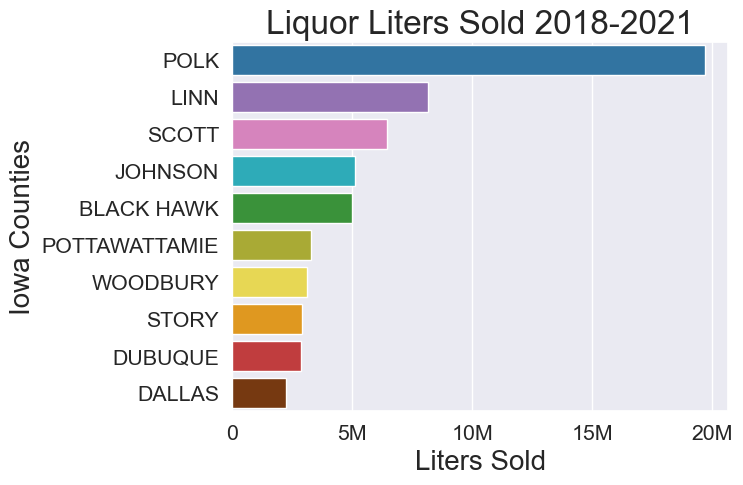

In [266]:
sns.barplot(x = 'liters_sold', y = 'county', data=df,  palette= county_colors)
ax = plt.gca()
ax.set_xlabel("Liters Sold" , size = 20)
ax.set_ylabel('Iowa Counties', size = 20)
ax.set_title("Liquor Liters Sold 2018-2021", size = 24)
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
plt.show()

Import US census data 

In [267]:
df2 = pd.read_csv('data/census_data.csv')

Combine Iowa liquor data: county, liters_sold and census data: population, percent_minors

In [268]:
df3 = pd.merge(df,df2, on ='county')
df3

,county,liters_sold,population,percent_minors
0,POLK,19676359.27,492401,0.245
1,LINN,8134965.33,230299,0.228
2,SCOTT,6441006.99,174669,0.235
3,JOHNSON,5092610.38,152854,0.197
4,BLACK HAWK,4973906.30,131144,0.220
5,POTTAWATTAMIE,3274895.58,93667,0.234
6,WOODBURY,3132042.70,105941,0.262
7,STORY,2887953.69,98537,0.164
8,DUBUQUE,2867264.56,99266,0.227
9,DALLAS,2241213.59,99678,0.269


Adjust population to show population of 18+ adults.

In [269]:
population_over_18 = df3['population']*(1-df3['percent_minors'])
df3['population_over_18'] = population_over_18
df3['population_over_18'] = df3['population_over_18'].astype(int)

liters_sold_per_adult = df3['liters_sold']/df3['population_over_18']
df3['liters_sold_per_adult'] = liters_sold_per_adult
df3

,county,liters_sold,population,percent_minors,population_over_18,liters_sold_per_adult
0,POLK,19676359.27,492401,0.245,371762,52.927301
1,LINN,8134965.33,230299,0.228,177790,45.756034
2,SCOTT,6441006.99,174669,0.235,133621,48.203553
3,JOHNSON,5092610.38,152854,0.197,122741,41.490703
4,BLACK HAWK,4973906.30,131144,0.220,102292,48.624587
5,POTTAWATTAMIE,3274895.58,93667,0.234,71748,45.644416
6,WOODBURY,3132042.70,105941,0.262,78184,40.059893
7,STORY,2887953.69,98537,0.164,82376,35.058193
8,DUBUQUE,2867264.56,99266,0.227,76732,37.367260
9,DALLAS,2241213.59,99678,0.269,72864,30.758860


Calculate total liters sold per adult over target period using data from combined sources.

In [270]:
df4 = df3[['county','liters_sold', 'population_over_18', 'liters_sold_per_adult']]
df4.sort_values(by= ['population_over_18'], ascending = False)

,county,liters_sold,population_over_18,liters_sold_per_adult
0,POLK,19676359.27,371762,52.927301
1,LINN,8134965.33,177790,45.756034
2,SCOTT,6441006.99,133621,48.203553
3,JOHNSON,5092610.38,122741,41.490703
4,BLACK HAWK,4973906.30,102292,48.624587
7,STORY,2887953.69,82376,35.058193
6,WOODBURY,3132042.70,78184,40.059893
8,DUBUQUE,2867264.56,76732,37.367260
9,DALLAS,2241213.59,72864,30.758860
5,POTTAWATTAMIE,3274895.58,71748,45.644416


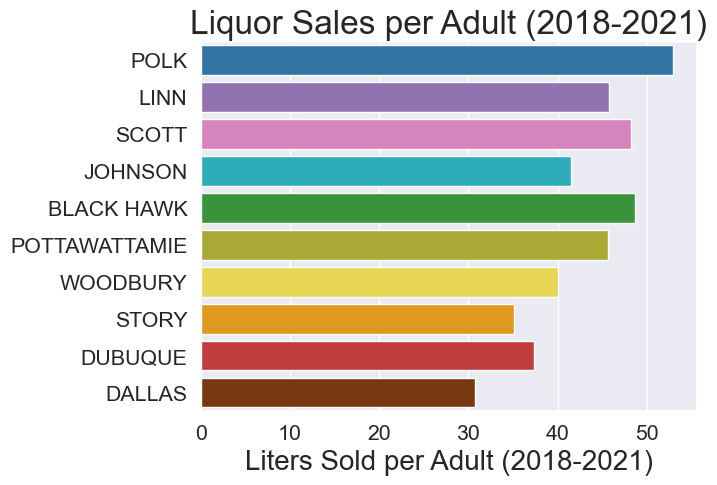

In [271]:
sns.barplot( x = 'liters_sold_per_adult', y = 'county', data=df4, palette= county_colors)
ax2 = plt.gca()
ax2.set_title( "Liquor Sales per Adult (2018-2021)" , size = 24 )
ax2.set_xlabel( "Liters Sold per Adult (2018-2021)" , size = 20 )
ax2.set_ylabel(None)    

plt.show()

Use Iowa liquor sales data to visualize total sales per county per year over target four year period.

In [272]:
all_county_all_year = """
WITH 
source_table AS (
  SELECT
    volume_sold_liters,
    date,
    store_number,
    IF (county ='POTTAWATTA','POTTAWATTAMIE', county) AS county,
    EXTRACT(YEAR FROM date) AS year
  FROM `bigquery-public-data.iowa_liquor_sales.sales`
  WHERE EXTRACT(YEAR FROM date) IN (2018, 2019, 2020, 2021)
  ),

store_county_map AS ( 
  SELECT 
    store_number,
    MAX(county) AS county
  FROM source_table
  WHERE store_number IS NOT NULL
  GROUP BY store_number
  ),

joined_table AS (
  SELECT a.volume_sold_liters, a.date, a.year, a.store_number, COALESCE(a.county, b.county) AS county
  FROM source_table a
  LEFT JOIN store_county_map b ON a.store_number = b.store_number
  ),

cleaned_source_table AS (
  SELECT 
    volume_sold_liters,
    date,
    year,
    county
  FROM joined_table
  WHERE county IN ("POLK", "LINN", "SCOTT", "JOHNSON", "BLACK HAWK", "WOODBURY", "DUBUQUE", "STORY", "DALLAS", "POTTAWATTAMIE")
  )

SELECT
    sum(volume_sold_liters) AS liters_sold,
    year,
    county
FROM cleaned_source_table
GROUP BY county, year 
ORDER BY year
""" .strip()

df5 = pd.read_sql_query(all_county_all_year, engine)

In [273]:
df5.dtypes

liters_sold    float64
year             int64
county          object
dtype: object

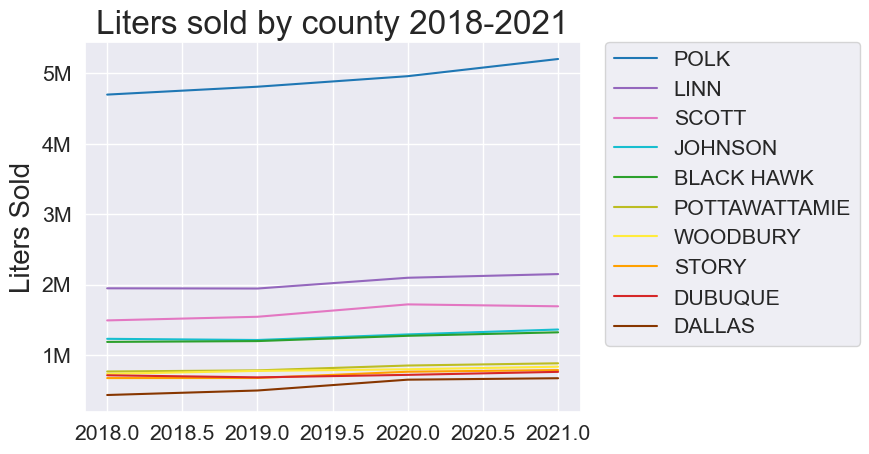

In [274]:
sns.lineplot(data = df5, x = 'year', y = 'liters_sold', hue= 'county', palette= county_colors,
hue_order = [
    "POLK","LINN","SCOTT","JOHNSON","BLACK HAWK","POTTAWATTAMIE","WOODBURY","STORY","DUBUQUE","DALLAS"
         ])
ax5  = plt.gca()
ax5.set(xlabel=None)
ax5.set_ylabel( "Liters Sold" , size = 20 )
ax5.set_title( "Liters sold by county 2018-2021", size = 24 )
ax5.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

Use Iowa liquor sales data to visualize total sales per county per month over target four year period.

In [275]:
county_month_year_sql_statement = """ 
WITH 
source_table AS (
  SELECT
    volume_sold_liters,
    date,
    store_number,
    IF (county ='POTTAWATTA','POTTAWATTAMIE', county) AS county,
    EXTRACT(YEAR FROM date) AS year
  FROM `bigquery-public-data.iowa_liquor_sales.sales`
  WHERE EXTRACT(YEAR FROM date) IN (2018, 2019, 2020, 2021)
),

store_county_map AS ( 
  SELECT 
    store_number,
    MAX(county) AS county
  FROM source_table
  WHERE store_number IS NOT NULL
  GROUP BY store_number
),

joined_table AS (
  SELECT a.volume_sold_liters, a.date, a.year, a.store_number, COALESCE(a.county, b.county) AS county
  FROM source_table a
  LEFT JOIN store_county_map b ON a.store_number = b.store_number
),

cleaned_source_table AS (
  SELECT 
    volume_sold_liters,
    date,
    year,
    county
  FROM joined_table
  WHERE county IN ("POLK", "LINN", "SCOTT", "JOHNSON", "BLACK HAWK", "WOODBURY", "DUBUQUE", "STORY", "DALLAS", "POTTAWATTAMIE")
)
  
  SELECT
  EXTRACT(YEAR FROM date) AS year,
  EXTRACT(MONTH FROM date) AS month,
  ROUND(SUM(volume_sold_liters)) AS liters_sold,
  county
  FROM cleaned_source_table
  GROUP BY year, month, county
  ORDER BY month, year, county
   """ .strip()

df6 = pd.read_sql_query(county_month_year_sql_statement, engine)
df6['Date'] = pd.to_datetime(df61.assign(Day=1).loc[:, ['year','month','Day']])
df6

,year,month,liters_sold,county,Date
0,2018,1,90066.0,BLACK HAWK,2018-01-01
1,2018,1,17174.0,DALLAS,2018-01-01
2,2018,1,54963.0,DUBUQUE,2018-01-01
3,2018,1,92307.0,JOHNSON,2018-01-01
4,2018,1,135373.0,LINN,2018-01-01
...,...,...,...,...,...
475,2021,12,498502.0,POLK,2021-12-01
476,2021,12,94978.0,POTTAWATTAMIE,2021-12-01
477,2021,12,150211.0,SCOTT,2021-12-01
478,2021,12,71981.0,STORY,2021-12-01


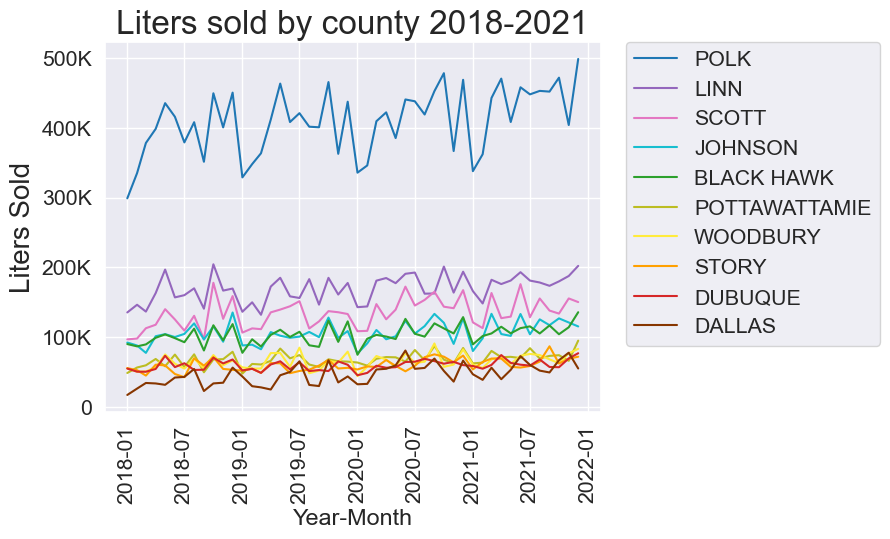

In [276]:
sns.lineplot(data = df6, x = 'Date', y = 'liters_sold', hue= 'county', palette = county_colors, hue_order = [
    "POLK","LINN","SCOTT","JOHNSON","BLACK HAWK","POTTAWATTAMIE","WOODBURY","STORY","DUBUQUE","DALLAS"])
ax5= plt.gca()
ax5.set(xlabel="Year-Month")
ax5.set_ylabel( "Liters Sold" , size = 20 )
ax5.set_title( "Liters sold by county 2018-2021", size = 24 )

ax5.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
plt.legend(bbox_to_anchor=(1.05, 1), loc = 'upper left', borderaxespad=0, markerscale=2)
plt.xticks(rotation= 90) 
plt.show()

Use Iowa liquor sales data to calculate percent change per year over target four year period. Data from 2017 used to establish percent change for 2018.  Percent change calculated as ((liters_sold_county - prev_liters_sold_county)/liters_sold_county)*100

In [277]:
percent_change_county = """
WITH 
source_table AS (
  SELECT
    volume_sold_liters,
    date,
    store_number,
    IF (county ='POTTAWATTA','POTTAWATTAMIE', county) AS county,
    CAST(EXTRACT(YEAR FROM date) AS string) AS year
  FROM `bigquery-public-data.iowa_liquor_sales.sales`
  WHERE EXTRACT(YEAR FROM date) IN (2017, 2018, 2019, 2020, 2021)
  ),

store_county_map AS ( 
  SELECT 
    store_number,
    MAX(county) AS county
  FROM source_table
  WHERE store_number IS NOT NULL
  GROUP BY store_number
  ),

joined_table AS (
  SELECT a.volume_sold_liters, a.date, a.year, COALESCE(a.county, b.county) AS county
  FROM source_table a
  LEFT JOIN store_county_map b ON a.store_number = b.store_number
  ),

cleaned_source_table AS (
  SELECT 
    volume_sold_liters,
    date,
    year,
    county
  FROM joined_table
  WHERE county IN ("POLK", "LINN", "SCOTT", "JOHNSON", "BLACK HAWK", "WOODBURY", "DUBUQUE", "STORY", "DALLAS", "POTTAWATTAMIE")
  ),

liters_county_sum AS (
  SELECT 
     SUM(volume_sold_liters) as liters_sold_county,
     year,
     county
  FROM cleaned_source_table
  GROUP BY year, county
  ),
  
lag_year AS(
  SELECT
      county,
      year,
      liters_sold_county,
      LAG(liters_sold_county) OVER(PARTITION BY county ORDER BY year) AS prev_liters_sold_county
  FROM liters_county_sum
  ),

percent_change_per_year AS (
  SELECT  
     county,
     year,
     ROUND(((liters_sold_county - prev_liters_sold_county)/liters_sold_county)*100) AS percent_change_year
  FROM lag_year)

  SELECT
        *
  FROM percent_change_per_year
  ORDER BY year, county
""" .strip()

df7 = pd.read_sql_query(percent_change_county, engine)

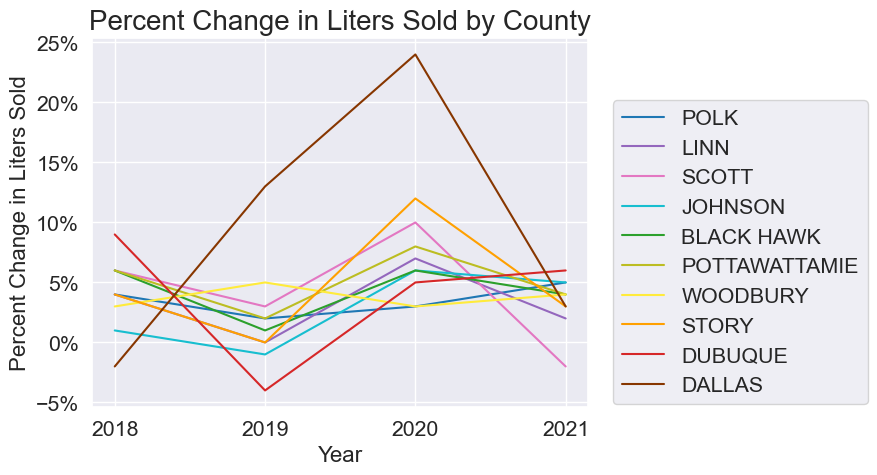

In [278]:
sns.lineplot(data = df7, x = 'year', y = 'percent_change_year', hue= 'county',  palette= county_colors,
            hue_order = ["POLK","LINN","SCOTT","JOHNSON","BLACK HAWK","POTTAWATTAMIE","WOODBURY","STORY","DUBUQUE","DALLAS"])
ax6= plt.gca()
ax6.set_xlabel("Year", size = 16 )
ax6.set_ylabel( "Percent Change in Liters Sold" , size = 16 )
ax6.set_title( "Percent Change in Liters Sold by County", size = 20 )
ax6.yaxis.set_major_formatter(tick.PercentFormatter(decimals = 0))
plt.legend(bbox_to_anchor=(1.05, .83), loc='upper left', borderaxespad=0, markerscale=2)
plt.show()